In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# magic command for matplotlib to enable printing directly in the jupyter notebook
%matplotlib inline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
#from sklearn.metrics import plot_confusion_matrix
#from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.utils import resample,shuffle

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV

from scipy.stats import randint


In [2]:
# PATHS

# get working directory
path_working = Path.cwd()

path_data_binary = str(path_working) + "\\" + "data" + "\\" + "binary" + "\\"

path_data_triple = str(path_working) + "\\" + "data" + "\\" + "triple" + "\\"

path_data_multiclass = str(path_working) + "\\" + "data" + "\\" + "multiclass" + "\\"

In [3]:
def create_dataframe (path):
    # Get the files from the path provided in the OP
    files = Path(path).glob('*.csv')  # .rglob to create iterator for subdirectories
    
    #Find all csv files in directory and concatenate them
    dfs = list()
    names = list()
    for file in files:
        data = pd.read_csv(file)
        # .stem is method for pathlib objects to get the filename without the extension
        # create another column in dataframe for filename
        data['file'] = file.stem
        names.append(file.stem)
        dfs.append(data)
    
    df = pd.concat(dfs, ignore_index=True)
    
    return df


In [4]:
df_raw_triple = create_dataframe(path_data_triple)

In [5]:
#drop last column taht shows csv filename source:
del df_raw_triple[df_raw_triple.columns[-1]]

df_raw_triple

R1-PA1:VH     R1-PM1:V   R1-PA2:VH     R1-PM2:V   R1-PA3:VH  \
0      70.399324  127673.0908  -49.572308  127648.0176 -169.578319   
1      73.688102  130280.7109  -46.300719  130255.6377 -166.278082   
2      73.733939  130305.7842  -46.254883  130280.7109 -166.232245   
3      74.083443  130581.5902  -45.899649  130556.5169 -165.882741   
4      74.553268  131083.0556  -45.424094  131057.9823 -165.424375   
...          ...          ...         ...          ...         ...   
78372 -58.934439  130706.9565 -178.900342  130681.8832   61.094490   
78373 -59.020382  131057.9823 -178.992015  131032.9090   61.002816   
78374 -59.031842  131083.0556 -179.003474  131032.9090   60.997087   
78375 -59.077678  131108.1288 -179.049311  131057.9823   60.951250   
78376 -59.203729  131158.2754 -179.169632  131108.1288   60.825200   

          R1-PM3:V  R1-PA4:IH   R1-PM4:I   R1-PA5:IH   R1-PM5:I  ...  \
0      127723.2374  65.689611  605.91099  -57.003571  626.78553  ...   
1      130355.9307  71.831719  483.59351  -50.947407  500.98896  ...   
2      130381.0040  71.808800  483.59351  -50.913030  500.98896  ...   
3      130656.8100  72.152575  482.86107  -50.437475  499.15786  ...   
4      131158.2754  72.118198  484.50906  -50.013486  497.69298  ...   
...            ...        ...        ...         ...        ...  ...   
78372  130782.1763 -60.149109  444.59108  178.808669  449.90127  ...   
78373  131108.1288 -61.507019  451.73237  177.857559  454.66213  ...   
78374  131133.2021 -61.535667  451.91548  177.857559  454.66213  ...   
78375  131158.2754 -61.839335  453.38036  177.725778  455.02835  ...   
78376  131208.4219 -62.446670  455.39457  177.336167  456.12701  ...   

       control_panel_log4  relay1_log  relay2_log  relay3_log  relay4_log  \
0                       0           0           0           0           0   
1                       0           0           0           0           0   
2                       0           0           0           0           0   
3                       0           0           0           0           0   
4                       0           0           0           0           0   
...                   ...         ...         ...         ...         ...   
78372                   0           0           0           0           0   
78373                   0           0           0           0           0   
78374                   0           0           0           0           0   
78375                   0           0           0           0           0   
78376                   0           0           0           0           0   

       snort_log1  snort_log2  snort_log3  snort_log4    marker  
0               0           0           0           0  NoEvents  
1               0           0           0           0  NoEvents  
2               0           0           0           0  NoEvents  
3               0           0           0           0  NoEvents  
4               0           0           0           0  NoEvents  
...           ...         ...         ...         ...       ...  
78372           0           0           0           0   Natural  
78373           0           0           0           0   Natural  
78374           0           0           0           0   Natural  
78375           0           0           0           0   Natural  
78376           0           0           0           0   Natural  

[78377 rows x 129 columns]

In [6]:
print(df_raw_triple.shape)

df_raw_triple['marker'].value_counts()

(78377, 129)


Attack      55663
Natural     18309
NoEvents     4405
Name: marker, dtype: int64

### ---> unbalanced classes

In [7]:
# .copy() is very important otherwise its just a pointer
df = df_raw_triple.copy()

In [8]:
def marker_to_numeric_triple(x):
        if x=='Attack': return 0
        if x=='Natural': return 1
        if x=='NoEvents': return 2
        
LABEL_MAP = {0 : "Attack", 1: "Natural", 2: "NoEvents"}

LABELNAMES = [LABEL_MAP[key] for key in LABEL_MAP]

df['marker'] = df['marker'].apply(marker_to_numeric_triple)
df

R1-PA1:VH     R1-PM1:V   R1-PA2:VH     R1-PM2:V   R1-PA3:VH  \
0      70.399324  127673.0908  -49.572308  127648.0176 -169.578319   
1      73.688102  130280.7109  -46.300719  130255.6377 -166.278082   
2      73.733939  130305.7842  -46.254883  130280.7109 -166.232245   
3      74.083443  130581.5902  -45.899649  130556.5169 -165.882741   
4      74.553268  131083.0556  -45.424094  131057.9823 -165.424375   
...          ...          ...         ...          ...         ...   
78372 -58.934439  130706.9565 -178.900342  130681.8832   61.094490   
78373 -59.020382  131057.9823 -178.992015  131032.9090   61.002816   
78374 -59.031842  131083.0556 -179.003474  131032.9090   60.997087   
78375 -59.077678  131108.1288 -179.049311  131057.9823   60.951250   
78376 -59.203729  131158.2754 -179.169632  131108.1288   60.825200   

          R1-PM3:V  R1-PA4:IH   R1-PM4:I   R1-PA5:IH   R1-PM5:I  ...  \
0      127723.2374  65.689611  605.91099  -57.003571  626.78553  ...   
1      130355.9307  71.831719  483.59351  -50.947407  500.98896  ...   
2      130381.0040  71.808800  483.59351  -50.913030  500.98896  ...   
3      130656.8100  72.152575  482.86107  -50.437475  499.15786  ...   
4      131158.2754  72.118198  484.50906  -50.013486  497.69298  ...   
...            ...        ...        ...         ...        ...  ...   
78372  130782.1763 -60.149109  444.59108  178.808669  449.90127  ...   
78373  131108.1288 -61.507019  451.73237  177.857559  454.66213  ...   
78374  131133.2021 -61.535667  451.91548  177.857559  454.66213  ...   
78375  131158.2754 -61.839335  453.38036  177.725778  455.02835  ...   
78376  131208.4219 -62.446670  455.39457  177.336167  456.12701  ...   

       control_panel_log4  relay1_log  relay2_log  relay3_log  relay4_log  \
0                       0           0           0           0           0   
1                       0           0           0           0           0   
2                       0           0           0           0           0   
3                       0           0           0           0           0   
4                       0           0           0           0           0   
...                   ...         ...         ...         ...         ...   
78372                   0           0           0           0           0   
78373                   0           0           0           0           0   
78374                   0           0           0           0           0   
78375                   0           0           0           0           0   
78376                   0           0           0           0           0   

       snort_log1  snort_log2  snort_log3  snort_log4  marker  
0               0           0           0           0       2  
1               0           0           0           0       2  
2               0           0           0           0       2  
3               0           0           0           0       2  
4               0           0           0           0       2  
...           ...         ...         ...         ...     ...  
78372           0           0           0           0       1  
78373           0           0           0           0       1  
78374           0           0           0           0       1  
78375           0           0           0           0       1  
78376           0           0           0           0       1  

[78377 rows x 129 columns]

In [9]:
# Check for infinite float entries
# "np.finfo(np.float64).max" returns the maximum finite value that can be represented by a 64-bit floating point number
# "df.values >= np.finfo(np.float64).max" returns a bollean array where "np.finfo(np.float64).max" is checked
# "np.where(df.values >= np.finfo(np.float64).max)" returns a array of indices where "df.values >= np.finfo(np.float64).max" is true

np.where(df.values >= np.finfo(np.float64).max)

(array([  738,   739,   753, ..., 78352, 78353, 78353], dtype=int64),
 array([26, 26, 26, ..., 55, 26, 55], dtype=int64))

### ----> we have infinite float entries

In [10]:
# Check for NaN values
np.isnan(df.values.any())

False

### ----> we have no NaN values in the dataframe

In [11]:
# Replace infinite updated data with nan

# "[np.inf, -np.inf]" specifies the values to be replaced
# "np.nan" specifies the value to replace the infinite values with.
# "inplace=True" modifies the Dataframe in place, so that the original df is updated the new values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN
df.dropna(inplace=True)

print(df.shape)

df['marker'].value_counts()

(72073, 129)


0    51445
1    16223
2     4405
Name: marker, dtype: int64

### ----> Due to cleaning up NaNs and infinites we lost about 6000 datapoints, which is not very harmful due to the fact that there are still 72000 rows

In [12]:
y = df['marker']

X = df.drop(['marker'],axis =1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57658, 128), (57658,), (14415, 128), (14415,))

In [14]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [15]:
# Create a random forest classifier
rf = RandomForestClassifier()

In [16]:
# Create a grid search object with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the grid search object to the training data
### grid_search.fit(X_train, y_train) TAKES HOURS!!!

# Print the best hyperparameters found by the grid search
#print(grid_search.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [17]:
# Define the parameter grid to search over
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "n_estimators": randint(50, 1000)}


In [18]:
%%time
# Perform randomized search with cross-validation
n_iter_search = 50
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)

# Fit the Randomized Search object to the data
#random_search.fit(X_train, y_train) TAKES HOURS!!!

Wall time: 0 ns


n_iter = 10 ---> 1h 16min

Best hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 789}

n_iter = 50 ---> 4h 30min

Best hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 571}


In [19]:
# Print the best hyperparameters found by the randomized search
print("Best hyperparameters:", random_search.best_params_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [20]:
params = {'bootstrap': False, 'max_depth': None, 'max_features': 3, 'min_samples_split': 2, 'n_estimators': 571}

In [21]:
model_rf_best = RandomForestClassifier(**params, random_state=42)
%time model_rf_best.fit(X_train, y_train) #jupyter magic command %time to measure the computing time for a single line of code


Wall time: 1min 38s


RandomForestClassifier(bootstrap=False, max_features=3, n_estimators=571,
                       random_state=42)

In [22]:
def evaluate_model(model, X_test, y_test, labelmap, binarylabels = False):
    """
    Evaluate a multiclass classification model using various metrics.
    
    Args:
        model (sklearn estimator): The model to evaluate.
        X_test (pandas dataframe): The test features.
        y_test (pandas series): The true labels
        labelmap (dict): The encoding of the names of the labels that are passed to report and matrix
        binarylabels (bool): If True model was built out of a binary classification problem
        
    Returns:
        sklearn confusionmatrix , sklearn report, metrics
    """
    
    #THIS IS EXTREMELY IMPORTANT:
    # scikit learn sorts labels in ascending order, thus 0's are first column/row and 1's are the second one
    # this means also that 0's are positive class in the report as well as in the confusion matrix!
    # To be on the safe side, here the labels are given by labelmap, where "Attack" has the key 0! So "Attack" is positive class!
    
    labelnames = [labelmap[key] for key in labelmap]

    
    # Predict the test labels using the trained model
    y_pred = model.predict(X_test)
    
    # map encoded labels to original labels
    y_true = [labelmap[i] for i in y_test]
    y_pred = [labelmap[i] for i in y_pred]
    
    # Compute the confusion matrix and print it
    confusionmatrix = confusion_matrix(y_true, y_pred, labels=labelnames)
    print("Confusion matrix:")
    print(confusionmatrix)
    
    # Compute the classification report and print it
    report = classification_report(y_true, y_pred, target_names=labelnames)
    print("Classification report:")
    print(report)
    
    if binarylabels == True:
        # Calculate metrics out of confusion matrix to compare
        
        tp, fn, fp, tn = confusionmatrix.ravel() # here also important first row, first columns are 0 so positive class so tp

        #  0   1
        # 0 [tp, fn]
        # 1 [fp, tn]

        precision = tp / (tp+fp)
        recall = tp / (tp+fn)
        specificity = tn / (tn+fp)

        metrics = [precision, recall, specificity]
        
    else:
        metrics = None
    
    return confusionmatrix, report, metrics

In [23]:
cm, rp, mets = evaluate_model(model_rf_best, X_test, y_test, LABEL_MAP, False)

Confusion matrix:
[[10144   136     9]
 [  700  2539     6]
 [   34     6   841]]
Classification report:
              precision    recall  f1-score   support

      Attack       0.93      0.99      0.96     10289
     Natural       0.95      0.78      0.86      3245
    NoEvents       0.98      0.95      0.97       881

    accuracy                           0.94     14415
   macro avg       0.95      0.91      0.93     14415
weighted avg       0.94      0.94      0.94     14415



In [24]:
print(mets)

None


<AxesSubplot:>

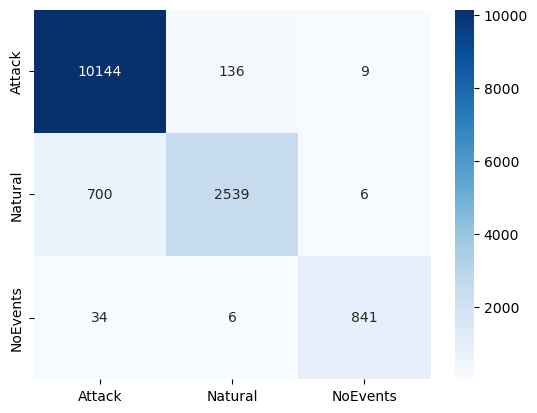

In [25]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELNAMES, yticklabels=LABELNAMES)

Text(0.5, 23.52222222222222, 'Predicted')

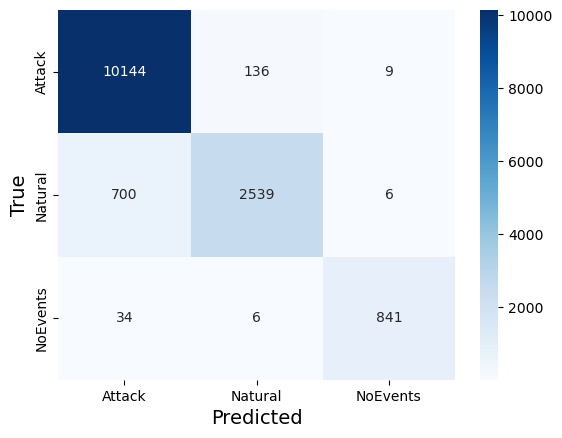

In [26]:
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELNAMES, yticklabels=LABELNAMES)
# add labels to the left and bottom borders
ax.set_ylabel("True", fontsize=14)
ax.set_xlabel("Predicted", fontsize=14)


# UPSAMPLING

In [ ]:
# Combine the X_train and y_train dataframes into a single datafframe
# NOT TOUCHING THE VAL OR TEST DATA!!!
df_train = pd.concat([X_train, y_train], axis=1)

In [ ]:
df_train['marker'].value_counts()

In [ ]:
df_not_minority = df_train[df_train['marker'] == 0] 
df_minority_Natural = df_train[df_train['marker'] == 1]
df_minority_NoEvents = df_train[df_train['marker'] == 2]

In [ ]:
#upsample the minority classes
df_minority_NoEvents_upsampled = resample(df_minority_NoEvents,random_state=42,n_samples=41156,replace=True)
df_minority_Natural_upsampled = resample(df_minority_Natural,random_state=42,n_samples=41156,replace=True)

In [ ]:
print(df_minority_NoEvents_upsampled.shape)
print(df_minority_Natural_upsampled.shape)

In [ ]:
#concatenate the upsampled dataframes
df_upsampled = pd.concat([df_minority_NoEvents_upsampled, df_minority_Natural_upsampled, df_not_minority ])
#df_upsampled

In [ ]:
y = df_upsampled['marker']

X = df_upsampled.drop(['marker'],axis =1)

In [ ]:
X_train, _, y_train, _ = train_test_split(X, y, test_size=0.000001, random_state=42)

print("upsampled Train data:")
print(X_train.shape, y_train.shape)

print("untouched Test data:")
print(X_test.shape, y_test.shape)

In [ ]:
#RF with Upsampled Data
model_rf_upsampled = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1, random_state=42)
%time model_rf_upsampled.fit(X_train, y_train) 

In [ ]:
cm, rp = evaluate_model(model_rf_upsampled, X_test, y_test, LABEL_MAP)

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELNAMES, yticklabels=LABELNAMES)

In [ ]:
import time
import numpy as np

start_time = time.time()
importances = model_rf_upsampled.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf_upsampled.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

In [ ]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]

# Select the top 20 features
#use argsort to obtain the indices that would sort the feature importances in descending order
#  then we use slicing to select the top 10 features
indices = np.argsort(importances)[::-1][:20]

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Feature importances")
plt.bar(range(20), importances[indices])
plt.xticks(range(20), X_train.columns[indices], rotation=90)
plt.show()

In [ ]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(model_rf_upsampled , threshold='median')
sfm.fit(X_train, y_train)
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)


In [ ]:
#RF with Upsampled Data
model_rf_upsampled_feature = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_jobs=-1, random_state=42)
%time model_rf_upsampled_feature.fit(X_important_train, y_train)


In [ ]:
cm, rp = evaluate_model(model_rf_upsampled_feature, X_important_test, y_test, LABEL_MAP)

In [ ]:
X_important_test.shape